#Training a new tokenizer from an old one


In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

# This can take a few minutes to load, so grab a coffee or tea while you wait!
raw_datasets = load_dataset("code_search_net", "python")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [ ]:
raw_datasets["train"]

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 412178
})

We’ll just use the whole_func_string column to train our tokenizer. We can look at an example of one these functions by indexing into the train split:

In [ ]:
print(raw_datasets["train"][123456]["whole_func_string"])

def has_elem(elem_ref):
    """
    Has element?
    :param elem_ref:
    :return:
    """
    if not is_elem_ref(elem_ref):
        return False
    elif elem_ref[0] == ElemRefObj:
        return hasattr(elem_ref[1], elem_ref[2])
    elif elem_ref[0] == ElemRefArr:
        return elem_ref[2] in elem_ref[1]


In [ ]:
training_corpus = (
    raw_datasets["train"][i : i + 1000]["whole_func_string"]
    for i in range(0, len(raw_datasets["train"]), 1000)
)

In [ ]:
gen = (i for i in range(10))
print(list(gen))
print(list(gen))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]


That’s why we define a function that returns a generator instead:



In [ ]:
def get_training_corpus():
    return (
        raw_datasets["train"][i : i + 1000]["whole_func_string"]
        for i in range(0, len(raw_datasets["train"]), 1000)
    )


training_corpus = get_training_corpus()

You can also define your generator inside a for loop by using the yield statement:



In [ ]:
def get_training_corpus():
    dataset = raw_datasets["train"]
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples["whole_func_string"]

##**Training a new tokenizer**


In [ ]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

First let’s have a look at how this tokenizer would treat an example function:



In [ ]:
example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'n',
 'umbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`',
 '."',
 '""',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

This tokenizer has a few special symbols, like Ġ and Ċ, which denote spaces and newlines, respectively. As we can see, this is not too efficient

Let’s train a new tokenizer and see if it solves those issues. For this, we’ll use the method train_new_from_iterator():

In [ ]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

In [ ]:
tokens = tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'numbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'ĊĠĠĠ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`."""',
 'ĊĠĠĠ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

In [ ]:
print(len(tokens))
print(len(old_tokenizer.tokenize(example)))

27
36


In [ ]:
example = """class LinearLayer():
    def __init__(self, input_size, output_size):
        self.weight = torch.randn(input_size, output_size)
        self.bias = torch.zeros(output_size)

    def __call__(self, x):
        return x @ self.weights + self.bias
    """
tokenizer.tokenize(example)

['class',
 'ĠLinear',
 'Layer',
 '():',
 'ĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'init',
 '__(',
 'self',
 ',',
 'Ġinput',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'weight',
 'Ġ=',
 'Ġtorch',
 '.',
 'randn',
 '(',
 'input',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 ')',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'bias',
 'Ġ=',
 'Ġtorch',
 '.',
 'zeros',
 '(',
 'output',
 '_',
 'size',
 ')',
 'ĊĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'call',
 '__(',
 'self',
 ',',
 'Ġx',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġreturn',
 'Ġx',
 'Ġ@',
 'Ġself',
 '.',
 'weights',
 'Ġ+',
 'Ġself',
 '.',
 'bias',
 'ĊĠĠĠĠ']

To make sure we can use it later, we need to save our new tokenizer. Like for models, this is done with the **save_pretrained ( )** method:

In [ ]:
tokenizer.save_pretrained("code-search-net-tokenizer")

('code-search-net-tokenizer/tokenizer_config.json',
 'code-search-net-tokenizer/special_tokens_map.json',
 'code-search-net-tokenizer/vocab.json',
 'code-search-net-tokenizer/merges.txt',
 'code-search-net-tokenizer/added_tokens.json',
 'code-search-net-tokenizer/tokenizer.json')

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

#Fast tokenizers’ special powers


- Slow tokenizers are those written in Python inside the 🤗 Transformers library, while the fast versions are the ones provided by 🤗 Tokenizers, which are written in Rust.

- the key functionality of fast tokenizers is that they always keep track of the original span of texts the final tokens come from — a feature we call **offset mapping**. This in turn unlocks features like mapping each word to the tokens it generated or mapping each character of the original text to the token it’s inside, and vice versa.

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

<class 'transformers.tokenization_utils_base.BatchEncoding'>


we get a BatchEncoding object in the tokenizer’s output:(above)

We have two ways to check if our tokenizer is a fast or a slow one.

In [4]:
tokenizer.is_fast

True

In [3]:
encoding.is_fast

True

 we can access the tokens without having to convert the IDs back to tokens:

In [6]:
encoding.tokens()

['[CLS]',
 'My',
 'name',
 'is',
 'S',
 '##yl',
 '##va',
 '##in',
 'and',
 'I',
 'work',
 'at',
 'Hu',
 '##gging',
 'Face',
 'in',
 'Brooklyn',
 '.',
 '[SEP]']

We can also use the word_ids() method to get the index of the word each token comes from:

In [7]:
encoding.word_ids()

[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

Special tokens [CLS] and [SEP] are used to determine if a token is at the start of a word or if two tokens are in the same word

We can map any word or token to characters in the original text
via the
- word_to_chars()
- token_to_chars() and char_to_word()
- char_to_token()

methods.

In [8]:
start, end = encoding.word_to_chars(3)
example[start:end]

'Sylvain'

#**Inside the token-classification pipeline**

The model used by default is dbmdz/bert-large-cased-finetuned-conll03-english; it performs NER on sentences:

In [9]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

[{'entity': 'I-PER',
  'score': 0.99938285,
  'index': 4,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': 0.99815494,
  'index': 5,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.99590707,
  'index': 6,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': 0.99923277,
  'index': 7,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': 0.9738931,
  'index': 12,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': 0.976115,
  'index': 13,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': 0.9887976,
  'index': 14,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': 0.9932106,
  'index': 16,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

We can also ask the pipeline to group together the tokens that correspond to the same entity:

In [10]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

The aggregation_strategy picked will change the scores computed for each grouped entity. With "simple" the score is just the mean of the scores of each token in the given entity: for instance, the score of “Sylvain” is the mean of the scores we saw in the previous example for the tokens S, ##yl, ##va, and ##in. Other strategies available are:

- "first", where the score of each entity is the score of the first token of that entity (so for “Sylvain” it would be 0.993828, the score of the token S)
- "max", where the score of each entity is the maximum score of the tokens in that entity (so for “Hugging Face” it would be 0.98879766, the score of “Face”)
- "average", where the score of each entity is the average of the scores of the words composing that entity (so for “Sylvain” there would be no difference from the "simple" strategy, but “Hugging Face” would have a score of 0.9819, the average of the scores for “Hugging”, 0.975, and “Face”, 0.98879)

##**From input to predictions**

We need to tokenize our input and pass it through the model. we instantiate the tokenizer and the model using the AutoXxx classes and then use them on our example

In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Since we’re using AutoModelForTokenClassification here, we get one set of logits for each token in the input sequence:

In [12]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])


We use a softmax function to convert those logits to probabilities, and we take the argmax to get predictions (note that we can take the argmax on the logits because the softmax does not change the order):

In [13]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


The model.config.id2label attribute contains the mapping of indexes to labels that we can use to make sense of the predictions:

In [14]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

With this map, we are ready to reproduce (almost entirely) the results of the first pipeline — we can just grab the score and label of each token that was not classified as O:


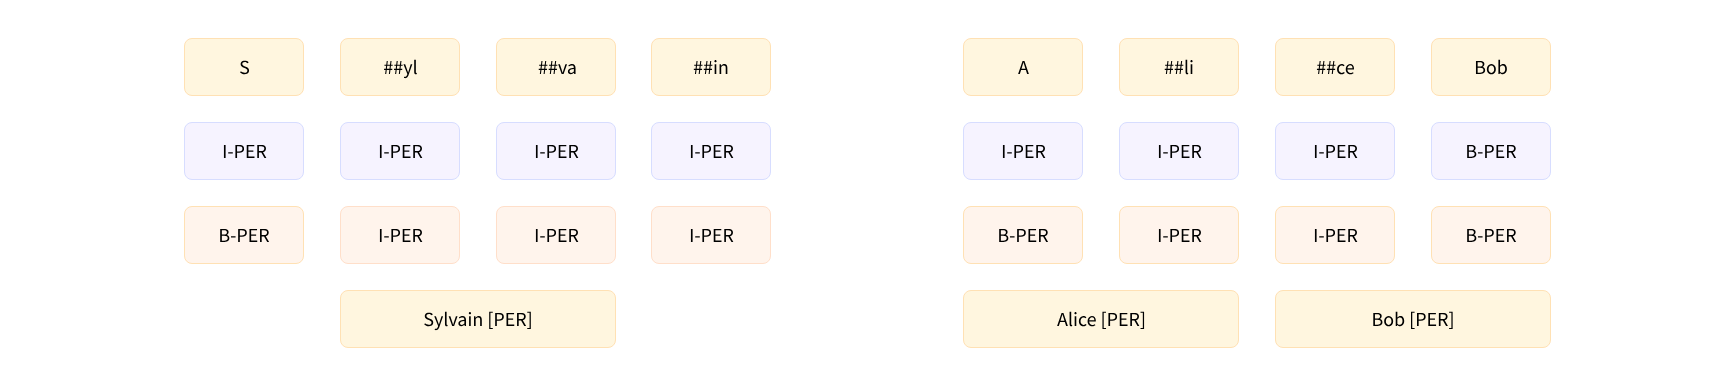

In [16]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)


[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S'}, {'entity': 'I-PER', 'score': 0.9981548190116882, 'word': '##yl'}, {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va'}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in'}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu'}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging'}, {'entity': 'I-ORG', 'score': 0.9887974858283997, 'word': 'Face'}, {'entity': 'I-LOC', 'score': 0.99321049451828, 'word': 'Brooklyn'}]


This is very similar to what we had before, with one exception: the pipeline also gave us information about the start and end of each entity in the original sentence. This is where our offset mapping will come into play. To get the offsets, we just have to set return_offsets_mapping=True when we apply the tokenizer to our inputs:

In [17]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 10),
 (11, 12),
 (12, 14),
 (14, 16),
 (16, 18),
 (19, 22),
 (23, 24),
 (25, 29),
 (30, 32),
 (33, 35),
 (35, 40),
 (41, 45),
 (46, 48),
 (49, 57),
 (57, 58),
 (0, 0)]

Each tuple is the span of text corresponding to each token, where (0, 0) is reserved for the special tokens. We saw before that the token at index 5 is ##yl, which has (12, 14) as offsets here. If we grab the corresponding slice in our example:

In [18]:
example[12:14]

'yl'

we get the proper span of text without the ##:(above)



In [19]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S', 'start': 11, 'end': 12}, {'entity': 'I-PER', 'score': 0.9981548190116882, 'word': '##yl', 'start': 12, 'end': 14}, {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va', 'start': 14, 'end': 16}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in', 'start': 16, 'end': 18}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu', 'start': 33, 'end': 35}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging', 'start': 35, 'end': 40}, {'entity': 'I-ORG', 'score': 0.9887974858283997, 'word': 'Face', 'start': 41, 'end': 45}, {'entity': 'I-LOC', 'score': 0.99321049451828, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


This is the same as what we got from the first pipeline!



**Grouping entities**

To write the code that post-processes the predictions while grouping entities, we will group together entities that are consecutive and labeled with I-XXX, except for the first one, which can be labeled as B-XXX or I-XXX (so, we stop grouping an entity when we get a O, a new type of entity, or a B-XXX that tells us an entity of the same type is starting):

In [20]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # Remove the B- or I-
        label = label[2:]
        start, _ = offsets[idx]

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)

[{'entity_group': 'PER', 'score': 0.998169407248497, 'word': 'Sylvain', 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': 0.9796018600463867, 'word': 'Hugging Face', 'start': 33, 'end': 45}, {'entity_group': 'LOC', 'score': 0.99321049451828, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


And we get the same results as with our second pipeline!

